# 0 Importación de datos


In [13]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from gluonts.dataset.repository import get_dataset
import os

# --- CONFIGURACIÓN RPY2 PARA WINDOWS ---
# 1. Configurar variables de entorno de R si es necesario (Opcional, ayuda en Windows)
# Si tienes errores de DLL, descomenta y ajusta la ruta a tu instalación de R:
# os.environ['R_HOME'] = r'C:\Program Files\R\R-4.X.X' 

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# Cargar la extensión de magia (esto permite usar %%R)
%load_ext rpy2.ipython

warnings.filterwarnings('ignore')

# NOTA: Eliminamos 'pandas2ri.activate()' porque causaba el error.
# La extensión rpy2.ipython moderna suele manejar la conversión automáticamente.

# Función de graficado interactivo (Estilo Bancolombia)
def plot_(title, *series):
    fig = go.Figure()
    
    # Agregar las series
    for x_variable, y_variable, label in series:
        fig.add_trace(go.Scatter(
            x=x_variable, y=y_variable, mode='lines', name=label, line=dict(width=1.5)
        ))
    
    # Actualización del Layout General
    fig.update_layout(
        title=dict(text=title, x=0.5, xanchor='center'),
        template='plotly_white',
        
        # --- CAMBIO 1: Márgenes ---
        # t=100: Da espacio arriba para que el Título no choque con los botones
        # b=100: Da espacio abajo para la Leyenda
        margin=dict(t=120, b=100), 
        
        # --- CAMBIO 2: Posición de la Leyenda ---
        # La movemos abajo del todo para limpiar la parte superior
        legend=dict(
            orientation="h",     # Horizontal
            yanchor="top",
            y=-0.3,              # Posición negativa (debajo del eje X y slider)
            xanchor="center",
            x=0.5                # Centrada
        )
    )

    # Configuración del Eje X y Botones
    fig.update_xaxes(
        type='date',
        rangeselector=dict(
            # Posición de los botones
            x=0,
            y=1.05,              # Los subimos un poquito más para separarlos de la gráfica
            buttons=list([
                dict(count=24, label="24h", step="hour", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True)
    )

    fig.update_yaxes(autorange=True, title="Valor")

    fig.show()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [14]:
%%R
# Instalamos las librerías de R necesarias para el análisis
if (!require("forecast")) install.packages("forecast")
if (!require("astsa")) install.packages("astsa")
if (!require("nonlinearTseries")) install.packages("nonlinearTseries")
if (!require("tidyverse")) install.packages("tidyverse")
if (!require("lubridate")) install.packages("lubridate")
if (!require("tseries")) install.packages("tseries")
if (!require("FinTS")) install.packages("FinTS")
if (!require("changepoint")) install.packages("changepoint")
if (!require("nortest")) install.packages("nortest")
if (!require("strucchange")) install.packages("strucchange")
if (!require("tsDyn")) install.packages("tsDyn")


library(tidyverse)
library(forecast)
library(astsa)
library(nonlinearTseries)
library(tseries)      # ADF, KPSS
library(FinTS)        # ARCH Test
library(forecast)     # MSTL
library(changepoint)  # Structural Breaks
library(nortest)      # Pruebas de normalidad extra
library(ggplot2)      # Gráficos bonitos
library(tsDyn)   # Manejo de fechas

In [15]:
# Cargar Dataset Electricity
dataset = get_dataset("electricity")
series_entry = next(iter(dataset.train)) # Tomamos la primera serie (índice 0)

# Recortamos a los últimos 4000 datos para agilizar el análisis visual
# y evitar saturar R
LIMIT = 2160
values = series_entry['target'][-LIMIT:]
start_date = pd.Timestamp(series_entry['start'].to_timestamp())
freq = series_entry['start'].freq

# Crear índice de fechas
timestamps = pd.date_range(
    end=start_date + pd.Timedelta(hours=len(series_entry['target'])), 
    periods=len(series_entry['target']), 
    freq=freq
)[-LIMIT:]

df = pd.DataFrame({'Date': timestamps, 'Consumo': values}) # Usamos 'Consumo' para mantener consistencia con el dataset
df.set_index('Date', inplace=True)

print(f"Dimensiones: {df.shape}")
display(df.head())

plot_('Consumo Eléctrico (Original)', (df.index, df["Consumo"], "Consumo"))

Dimensiones: (2160, 1)


,Consumo
Date,
2014-02-25 21:00:00,11.0
2014-02-25 22:00:00,11.0
2014-02-25 23:00:00,11.0
2014-02-26 00:00:00,11.0
2014-02-26 01:00:00,11.0


In [16]:
# Reseteamos índice para pasarlo a R limpiamente
df_r = df.reset_index()
# Importante: R maneja fechas mejor como strings ISO o objetos Date
df_r['Date'] = df_r['Date'].dt.strftime('%Y-%m-%d %H:%M:%S')

# CORRECCIÓN DE VALOR: Box-Cox falla con 0.
# Detectamos si hay ceros y calculamos un offset
min_val = df_r['Consumo'].min()
offset = 0
if min_val <= 0:
    offset = abs(min_val) + 1.0
    print(f"⚠️ Se detectaron valores <= 0. Se aplicará un offset de {offset} para análisis Box-Cox.")

df_r['Consumo_Offset'] = df_r['Consumo'] + offset

⚠️ Se detectaron valores <= 0. Se aplicará un offset de 1.0 para análisis Box-Cox.


In [17]:
%%R -i df_r
# Convertimos la columna Date a formato fecha-hora en R
df_r$Date <- as.POSIXct(df_r$Date, format="%Y-%m-%d %H:%M:%S")
head(df_r)

                 Date Consumo Consumo_Offset
0 2014-02-25 21:00:00      11             12
1 2014-02-25 22:00:00      11             12
2 2014-02-25 23:00:00      11             12
3 2014-02-26 00:00:00      11             12
4 2014-02-26 01:00:00      11             12
5 2014-02-26 02:00:00      12             13


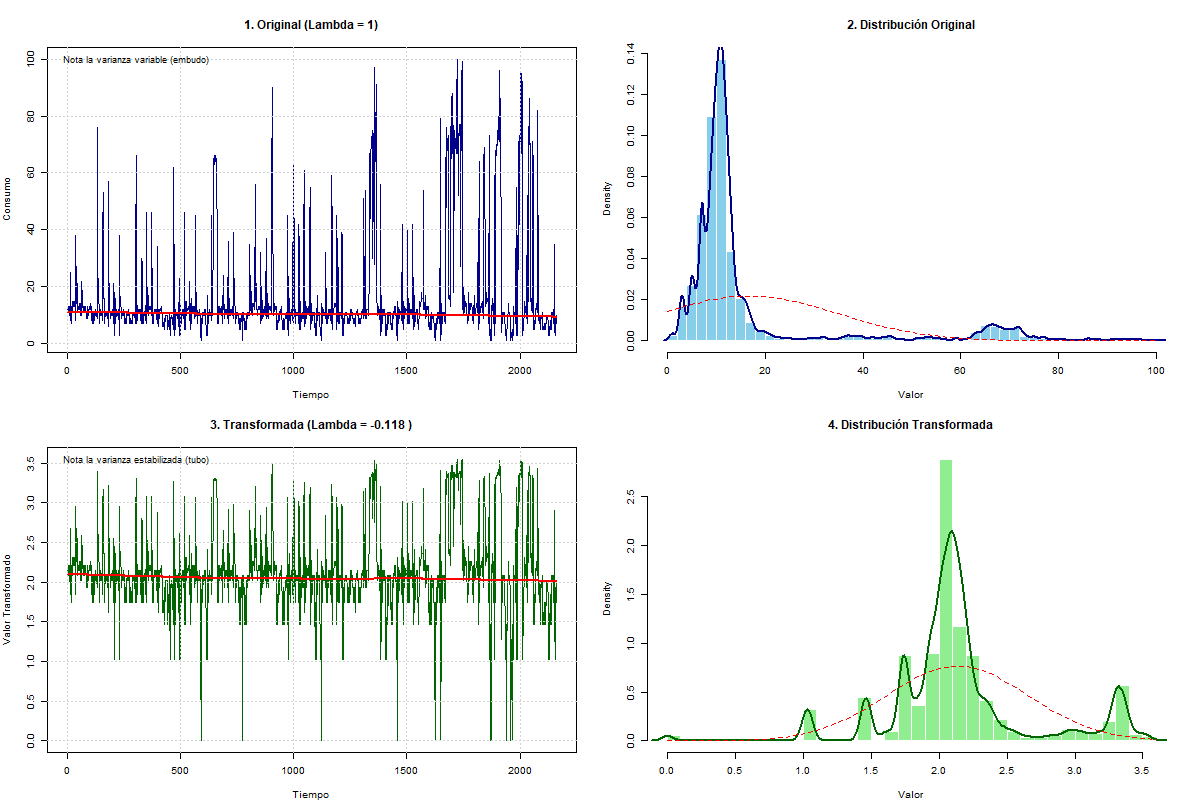

In [18]:
%%R -w 1200 -h 800

# Aseguramos librerías
library(forecast)

# 1. Definimos los datos y calculamos Lambda (Usamos Guerrero por ser series de tiempo)
# Puedes cambiar a method="loglik" si quieres ver el óptimo para normalidad
lambda_opt <- BoxCox.lambda(df_r$Consumo_Offset, method = "guerrero")

# 2. Creamos los datos transformados
data_orig <- df_r$Consumo_Offset
data_trans <- BoxCox(df_r$Consumo_Offset, lambda_opt)

# 3. Configuración del panel de gráficos (2 filas, 2 columnas)
par(mfrow=c(2,2), mar=c(4,4,4,2))

# --- GRÁFICOS ORIGINALES ---

# A. Serie de Tiempo Original
plot(data_orig, type="l", col="darkblue", 
     main=paste("1. Original (Lambda = 1)"),
     ylab="Consumo", xlab="Tiempo")
grid()
# Agregamos una linea de tendencia visual
lines(lowess(data_orig), col="red", lwd=2)
legend("topleft", legend="Nota la varianza variable (embudo)", bty="n", cex=0.9)

# B. Histograma Original
hist(data_orig, breaks=50, col="skyblue", border="white", probability=TRUE,
     main="2. Distribución Original", xlab="Valor")
lines(density(data_orig), col="darkblue", lwd=2)
# Curva normal teórica para comparar
curve(dnorm(x, mean=mean(data_orig), sd=sd(data_orig)), add=TRUE, col="red", lty=2)


# --- GRÁFICOS TRANSFORMADOS ---

# C. Serie de Tiempo Transformada
plot(data_trans, type="l", col="darkgreen", 
     main=paste("3. Transformada (Lambda =", round(lambda_opt, 3), ")"),
     ylab="Valor Transformado", xlab="Tiempo")
grid()
lines(lowess(data_trans), col="red", lwd=2)
legend("topleft", legend="Nota la varianza estabilizada (tubo)", bty="n", cex=0.9)

# D. Histograma Transformado
hist(data_trans, breaks=50, col="lightgreen", border="white", probability=TRUE,
     main="4. Distribución Transformada", xlab="Valor")
lines(density(data_trans), col="darkgreen", lwd=2)
# Curva normal teórica para comparar
curve(dnorm(x, mean=mean(data_trans), sd=sd(data_trans)), add=TRUE, col="red", lty=2)

# Restablecer configuración de gráficos
par(mfrow=c(1,1))

[1] "Lambda estimado: -0.118109631676046"


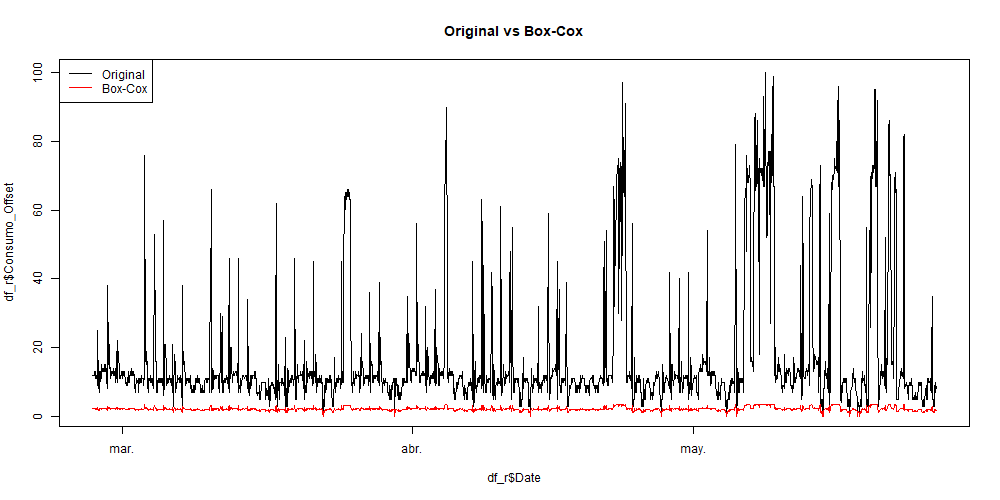

In [19]:
%%R -w 1000 -h 500
# Usamos la columna con Offset para evitar el error "Data must be positive"
# lambda calculation
Lambda_est <- BoxCox.lambda(df_r$Consumo_Offset, method = "guerrero")

print(paste("Lambda estimado:", Lambda_est))

# Graficamos en R
plot(df_r$Date, df_r$Consumo_Offset, type="l", col="black", main="Original vs Box-Cox")
lines(df_r$Date, BoxCox(df_r$Consumo_Offset, Lambda_est), col="red")
legend("topleft", legend=c("Original", "Box-Cox"), col=c("black", "red"), lty=1)

# Guardamos la variable transformada en el dataframe de R
df_r$BoxCox_Consumo <- BoxCox(df_r$Consumo_Offset, Lambda_est)

In [20]:
# Traer la variable transformada de vuelta a Python
df['BoxCox_Consumo'] = %R df_r$BoxCox_Consumo
lambda_r = %R Lambda_est

plot_(f'Estabilización de la Varianza (Box-cox λ ={lambda_r[0]:.3f} )', 
      (df.index, df["Consumo"], "Datos Originales"),
      (df.index, df["BoxCox_Consumo"], "BoxCox Transformado"))

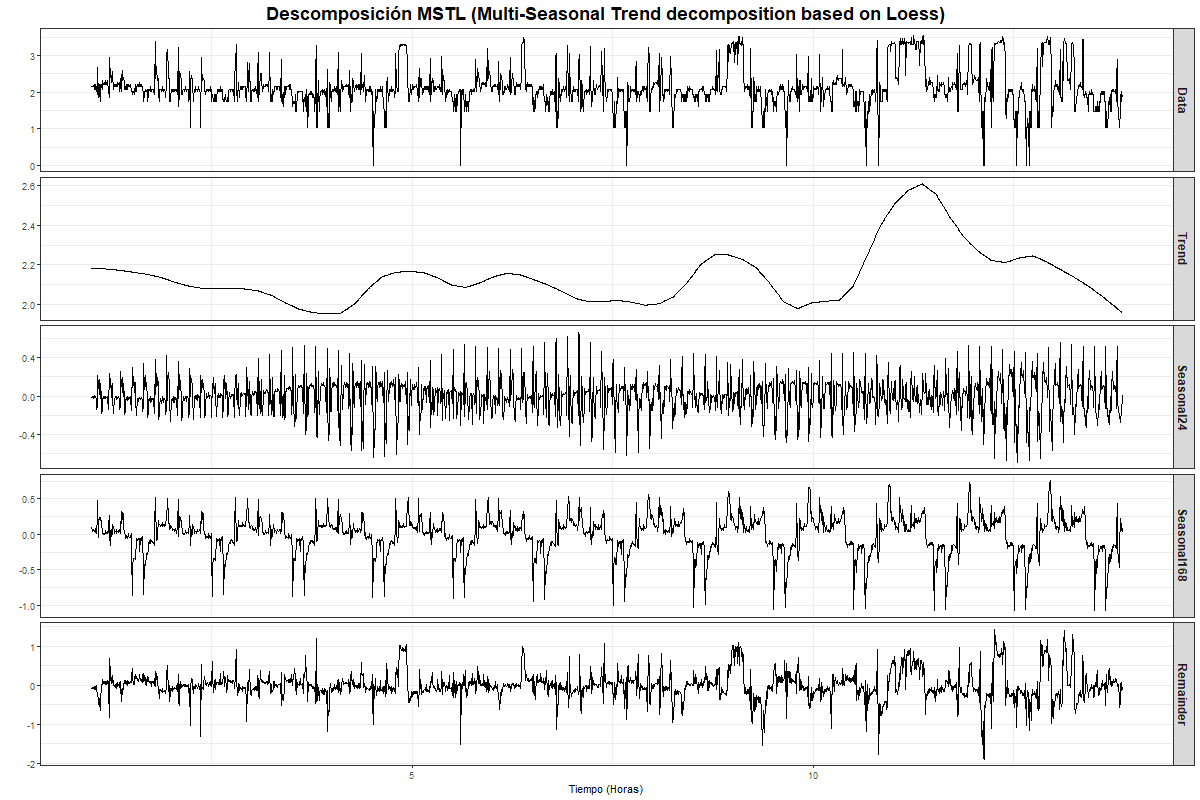

In [21]:
%%R -w 1200 -h 800

# Usamos la serie BoxCox (con estacionalidad) para descomponerla
# Definimos los periodos: 24 (diario) y 168 (semanal)
y_msts <- msts(df_r$BoxCox_Consumo, seasonal.periods=c(24, 168))

# Ajustamos descomposición MSTL
fit_mstl <- mstl(y_msts)

# Graficamos
autoplot(fit_mstl) + 
  ggtitle("Descomposición MSTL (Multi-Seasonal Trend decomposition based on Loess)") +
  xlab("Tiempo (Horas)") +
  theme_bw() +
  theme(plot.title = element_text(size=18, face="bold", hjust=0.5),
        strip.text = element_text(size=12, face="bold"))

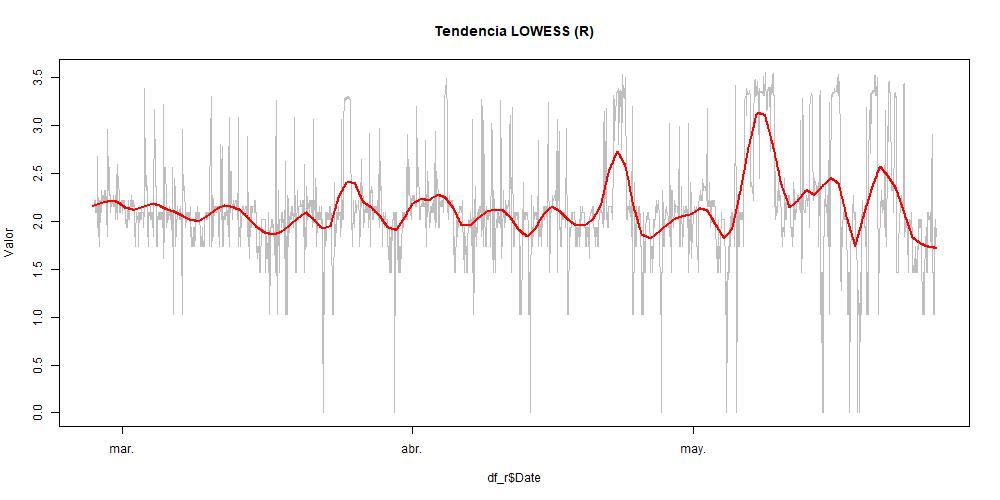

In [22]:
%%R -w 1000 -h 500
# Calcular LOWESS sobre la data transformada
# f = suavizado. Para datos horarios (4000 pts), usamos un f pequeño
trend_lowess_R <- lowess(df_r$BoxCox_Consumo, f = 0.05, iter = 0)

# Extraer tendencia y residuo
df_r$Trend <- trend_lowess_R$y
df_r$Trend_Removed <- df_r$BoxCox_Consumo - df_r$Trend

# Gráfico R estilo base
plot(df_r$Date, df_r$BoxCox_Consumo, type='l', col='gray', main='Tendencia LOWESS (R)', ylab='Valor')
lines(df_r$Date, df_r$Trend, col='red', lwd=2)

In [24]:
# Traemos las columnas calculadas en R
df['Trend'] = %R df_r$Trend
df['Trend_Removed'] = %R df_r$Trend_Removed

plot_('Eliminación de Tendencia por Lowess', 
      (df.index, df["BoxCox_Consumo"], "BoxCox"),
      (df.index, df["Trend"], "Tendencia Suavizada"),
      (df.index, df["Trend_Removed"], "Sin Tendencia (Residuo)"))

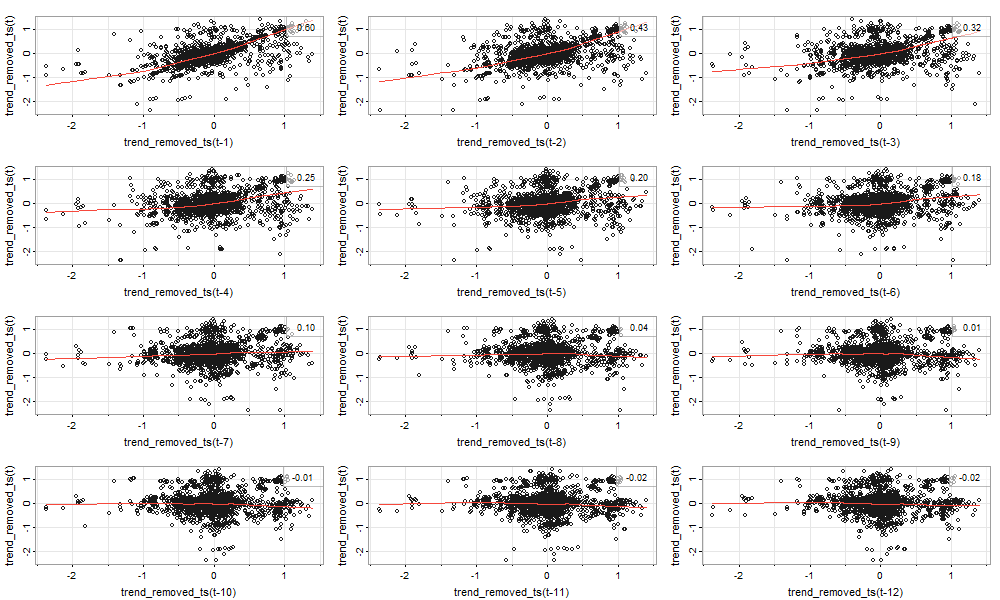

In [25]:
%%R -w 1000 -h 600
# Pasamos la serie sin tendencia a un objeto ts (time series)
# Frecuencia 24 porque son datos horarios
trend_removed_ts <- ts(df_r$Trend_Removed, frequency = 24)

options(repr.plot.width=20, repr.plot.height=6)
library(astsa)

# Graficamos los primeros 12 lags con correlación y línea lowess
astsa::lag1.plot(trend_removed_ts, 12)

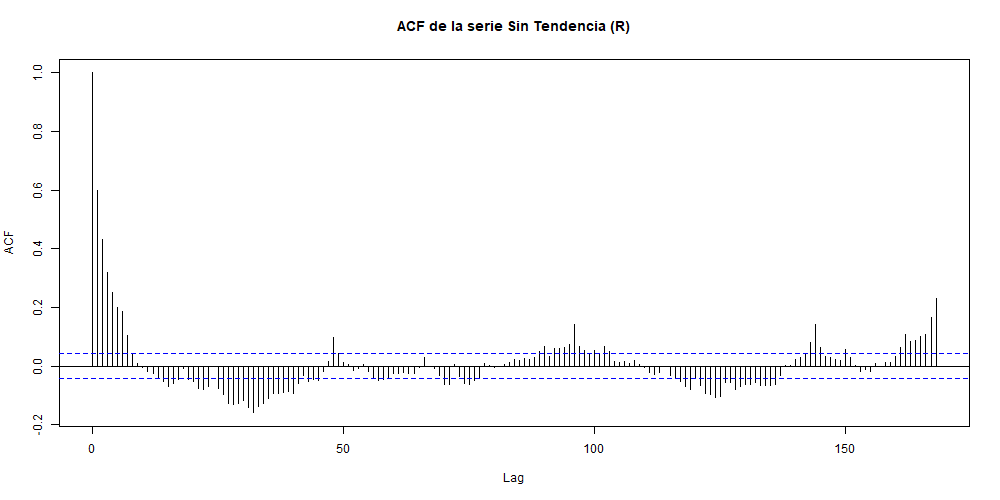

In [26]:
%%R -w 1000 -h 500
# ACF con un lag.max amplio para ver ciclos diarios (24) y semanales (168)
acf(df_r$Trend_Removed, lag.max = 168, main = "ACF de la serie Sin Tendencia (R)")

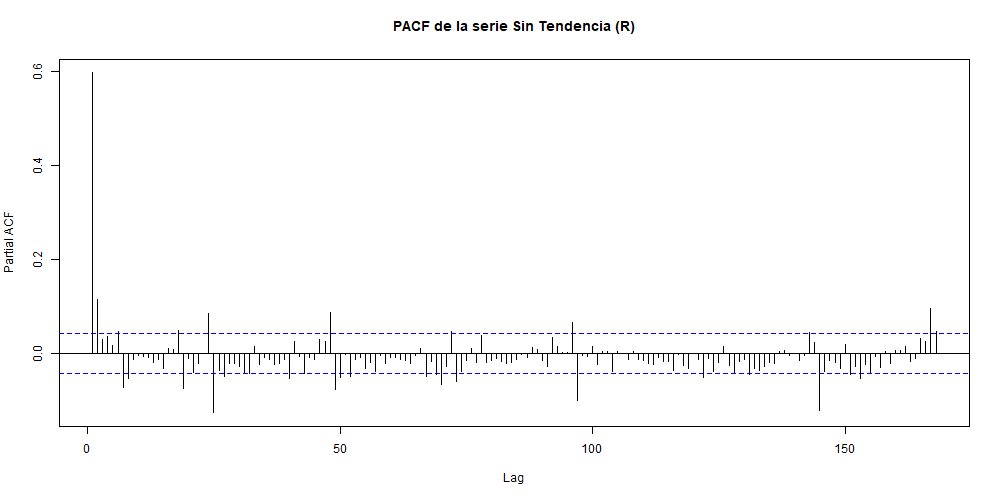

In [27]:
%%R -w 1000 -h 500
# PACF con un lag.max amplio para ver ciclos diarios (24) y semanales (168)
pacf(df_r$Trend_Removed, lag.max = 168, main = "PACF de la serie Sin Tendencia (R)")

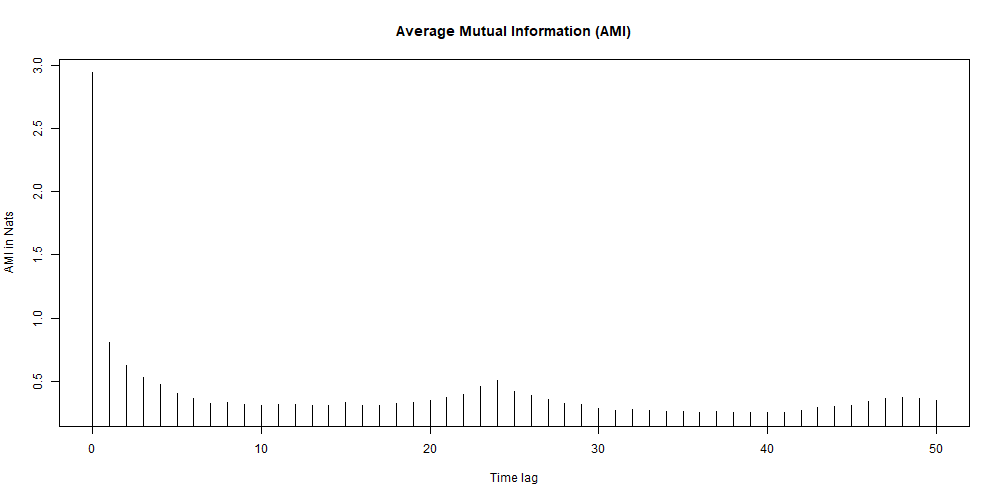

In [28]:
%%R -w 1000 -h 500
library(nonlinearTseries)
# Información mutua para detectar dependencias no lineales
mi <- mutualInformation(df_r$Trend_Removed, lag.max = 50, n.partitions = 50, 
                        units = "Nats", do.plot = TRUE, main="Información Mutua (R)")

In [29]:
%%R
# Función auxiliar para interpretar p-values limpiamente
interpret_p <- function(p_val, alpha=0.05, h0_desc, h1_desc) {
    res <- ifelse(p_val < alpha, h1_desc, h0_desc)
    signif <- ifelse(p_val < 0.001, "***", ifelse(p_val < 0.01, "**", ifelse(p_val < 0.05, "*", "ns")))
    cat(sprintf("   -> p-value: %.5f (%s) \n   -> Conclusión: %s\n", p_val, signif, res))
}


 1. PRUEBAS DE ESTACIONARIEDAD (Unit Root Tests)

[A] Augmented Dickey-Fuller Test (ADF)
    H0: La serie TIENE raiz unitaria (No estacionaria)
   -> p-value: 0.01000 (*) 
   -> Conclusion: [OK] Estacionaria

[B] KPSS Test
    H0: La serie ES estacionaria alrededor de tendencia
   -> p-value: 0.10000 (ns) 
   -> Conclusion: [OK] Estacionaria

NOTA: Buscamos 'OK' en ambas pruebas.


In addition: Warning messages:
1: In adf.test(serie_analisis) : p-value smaller than printed p-value
2: In kpss.test(serie_analisis, null = "Level") :
  p-value greater than printed p-value


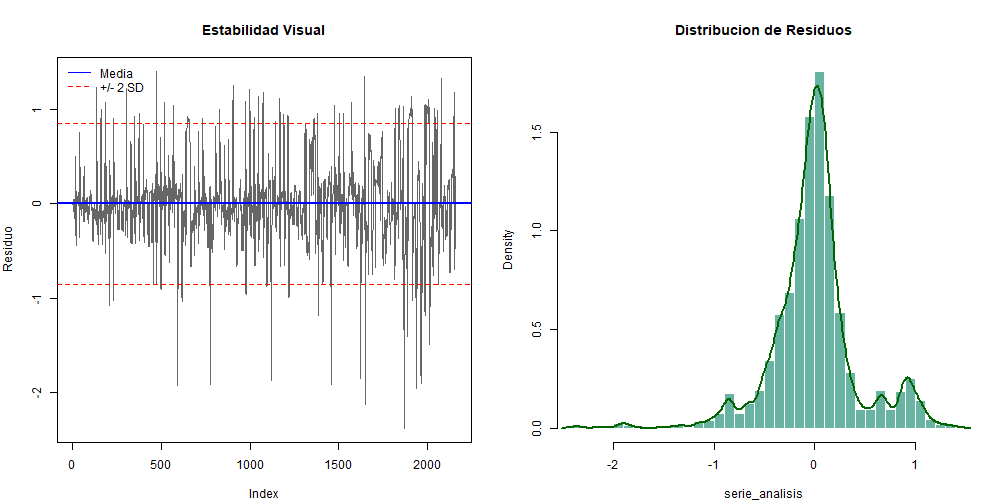

In [30]:
%%R -w 1000 -h 500

par(mfrow=c(1,2), mar=c(4,4,4,2))

# Datos a analizar
serie_analisis <- na.omit(df_r$Trend_Removed)

# 1. Grafico de la serie
plot(serie_analisis, type='l', col='gray40', main="Estabilidad Visual", ylab="Residuo")
abline(h=mean(serie_analisis), col="blue", lwd=2)
abline(h=mean(serie_analisis) + 2*sd(serie_analisis), col="red", lty=2)
abline(h=mean(serie_analisis) - 2*sd(serie_analisis), col="red", lty=2)
legend("topleft", legend=c("Media", "+/- 2 SD"), col=c("blue", "red"), lty=c(1,2), bty="n")

# 2. Histograma
hist(serie_analisis, breaks=40, col="#69b3a2", border="white", main="Distribucion de Residuos", probability=TRUE)
lines(density(serie_analisis), col="darkgreen", lwd=2)

# --- FUNCION AUXILIAR LIMPIA (SIN TILDES) ---
interpret_p <- function(p_val, alpha=0.05, h0_desc, h1_desc) {
    # Seleccionamos el mensaje basado en el p-value
    res <- ifelse(p_val < alpha, h1_desc, h0_desc)
    
    # Marcas de significancia visuales (ASCII)
    signif <- ifelse(p_val < 0.001, "***", ifelse(p_val < 0.01, "**", ifelse(p_val < 0.05, "*", "ns")))
    
    # Usamos cat sin caracteres especiales
    cat(sprintf("   -> p-value: %.5f (%s) \n   -> Conclusion: %s\n", p_val, signif, res))
}

# --- REPORTES DE TEXTO ---
cat("\n=======================================================\n")
cat(" 1. PRUEBAS DE ESTACIONARIEDAD (Unit Root Tests)\n")
cat("=======================================================\n")

# A. ADF Test
cat("\n[A] Augmented Dickey-Fuller Test (ADF)\n")
cat("    H0: La serie TIENE raiz unitaria (No estacionaria)\n")
test_adf <- adf.test(serie_analisis)
interpret_p(test_adf$p.value, h0_desc="[FALLO] No Estacionaria", h1_desc="[OK] Estacionaria")

# B. KPSS Test
cat("\n[B] KPSS Test\n")
cat("    H0: La serie ES estacionaria alrededor de tendencia\n")
test_kpss <- kpss.test(serie_analisis, null="Level")
interpret_p(test_kpss$p.value, h0_desc="[OK] Estacionaria", h1_desc="[FALLO] No Estacionaria")

cat("\nNOTA: Buscamos 'OK' en ambas pruebas.\n")

   BATERÍA DE TESTS DE NO LINEALIDAD (Python)

----------------------------------------------------------------------
 [1] TEST BDS (Aproximación)
----------------------------------------------------------------------
  Estadístico Z: 3.7588
  p-value: 0.000171 ***
  ✓ Fuerte evidencia de dependencia no lineal

----------------------------------------------------------------------
 [2] TEST McLEOD-LI (Ljung-Box en Residuos²)
----------------------------------------------------------------------
  Estadístico LB: 1551.8782
  p-value: 0.000000 ***
  ✓ Fuerte evidencia de efectos ARCH/GARCH
  → Recomendación: Usar modelos con varianza condicional

----------------------------------------------------------------------
 [3] TEST DE TSAY (No linealidad en estructura)
----------------------------------------------------------------------
  Estadístico F: 26.9655
  R² (no lineal): 0.1016
  p-value: 0.000000 ***
  ✓ Fuerte no linealidad detectada
  → Modelos lineales serán insuficientes

------

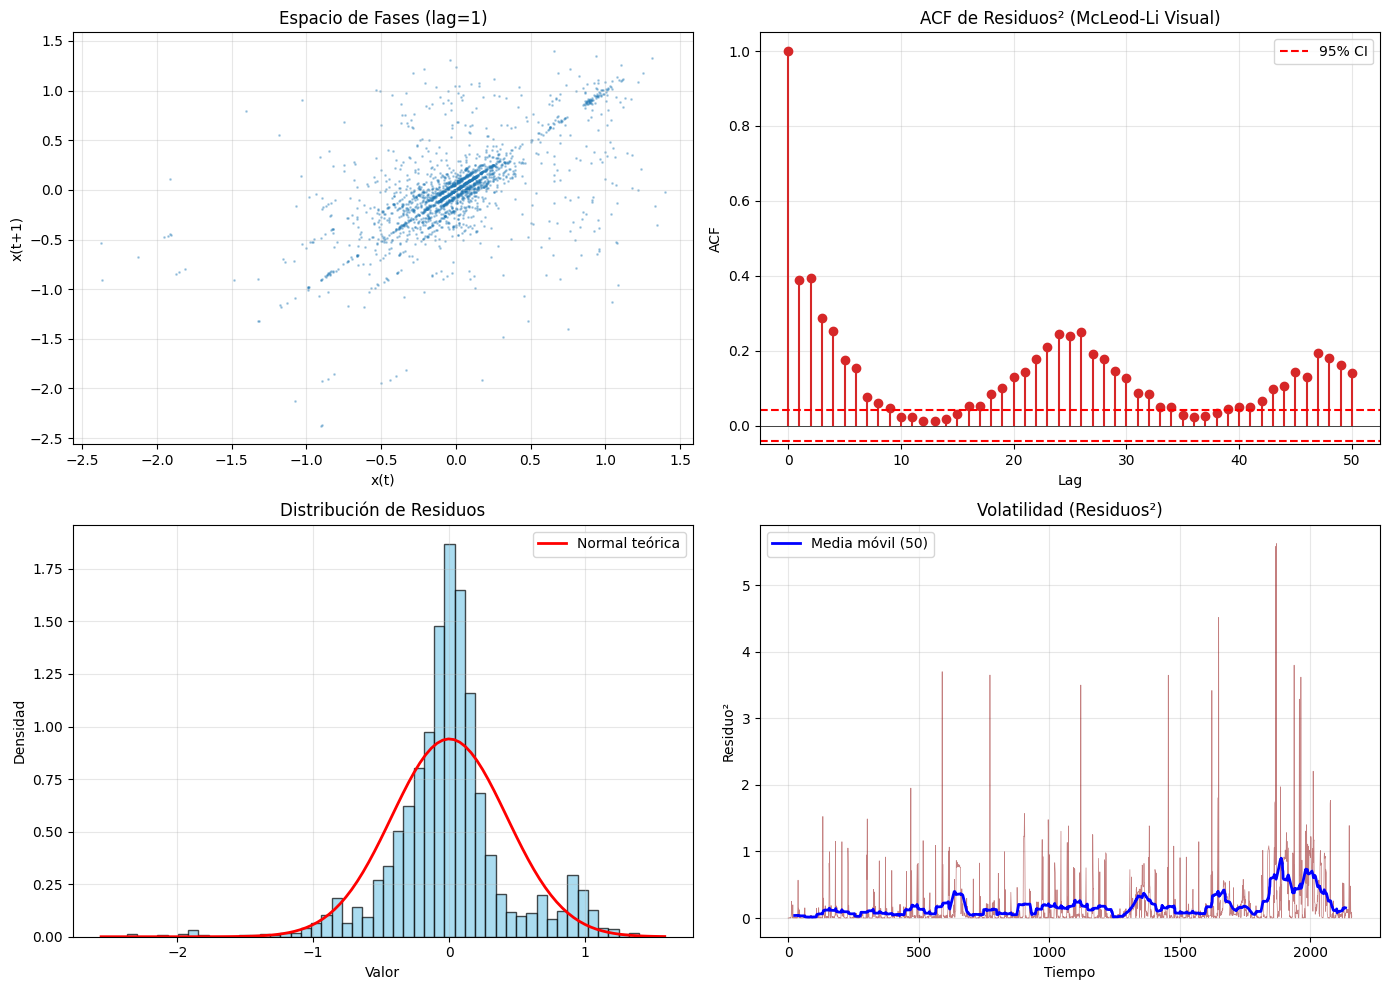


   RESUMEN Y RECOMENDACIONES PARA TU TESIS

Estos tests te permiten justificar:

1. BDS rechaza → Dependencia compleja detectada
   → Justifica el uso de LSTM/GRU/Transformer sobre ARMA

2. McLeod-Li rechaza → Varianza condicional presente
   → Usar predicción probabilística (quantiles) es ESENCIAL
   → CRPS es mejor métrica que MSE

3. Tsay rechaza linealidad → Estructura no lineal
   → Modelos lineales (ARMA/ETS) tendrán desempeño limitado

4. H > 0.5 → Memoria larga
   → Considerar horizontes de predicción largos
   → Efectos de largo plazo son importantes



In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# TESTS DE NO LINEALIDAD EN PYTHON (ALTERNATIVA ROBUSTA)
# ============================================================================

def bds_test_python(series, m=2, epsilon=None):
    """
    Test BDS simplificado (aproximación)
    m: embedding dimension
    epsilon: radio (si es None, usa 0.5 * std)
    """
    series = np.array(series)
    n = len(series)
    
    if epsilon is None:
        epsilon = 0.5 * np.std(series)
    
    # Calcular correlación integral
    def correlation_integral(data, eps, m):
        N = len(data) - m + 1
        vectors = np.array([data[i:i+m] for i in range(N)])
        
        count = 0
        for i in range(N):
            for j in range(i+1, N):
                if np.max(np.abs(vectors[i] - vectors[j])) < eps:
                    count += 1
        
        C_m = 2 * count / (N * (N - 1))
        return C_m if C_m > 0 else 1e-10
    
    # Calcular para diferentes dimensiones
    C_1 = correlation_integral(series, epsilon, 1)
    C_m = correlation_integral(series, epsilon, m)
    
    # Estadístico BDS aproximado
    V_mn = n * (C_m - C_1**m)
    
    # Varianza aproximada (simplificada)
    sigma = np. sqrt(4 * (C_1**(2*m) + 2*sum([C_1**(2*k) for k in range(1,m)])))
    
    if sigma > 0:
        z_stat = V_mn / (sigma * np.sqrt(n))
    else:
        z_stat = 0
    
    # P-value usando distribución normal
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    
    return z_stat, p_value

def mcleod_li_test(series, lags=24):
    """
    Test de McLeod-Li para dependencia no lineal
    (Ljung-Box en residuos al cuadrado)
    """
    # Centrar la serie
    residuals = series - np.mean(series)
    
    # Test en residuos al cuadrado
    squared_resid = residuals ** 2
    
    # Ljung-Box
    lb_result = acorr_ljungbox(squared_resid, lags=[lags], return_df=True)
    
    return lb_result

def tsay_test(series, lag=1, order=2):
    """
    Test de Tsay para no linealidad
    Basado en regresión de residuos al cuadrado
    """
    from sklearn.linear_model import LinearRegression
    
    n = len(series)
    X = []
    y = []
    
    for i in range(lag * order, n):
        features = []
        for j in range(1, order + 1):
            features.append(series[i - j * lag])
        X.append(features)
        y.append(series[i])
    
    X = np.array(X)
    y = np.array(y)
    
    # Regresión lineal
    model = LinearRegression()
    model.fit(X, y)
    residuals = y - model.predict(X)
    
    # Construir características no lineales (cuadrados y productos cruzados)
    X_nonlinear = []
    for i in range(len(X)):
        row = list(X[i])
        # Agregar cuadrados
        row.extend([x**2 for x in X[i]])
        # Agregar productos cruzados
        for j in range(len(X[i])):
            for k in range(j+1, len(X[i])):
                row.append(X[i][j] * X[i][k])
        X_nonlinear.append(row)
    
    X_nonlinear = np.array(X_nonlinear)
    
    # Regresión de residuos² contra términos no lineales
    from sklearn.linear_model import Ridge
    model_nl = Ridge(alpha=1.0)
    model_nl.fit(X_nonlinear, residuals**2)
    
    # R² como medida de no linealidad
    r2 = model_nl.score(X_nonlinear, residuals**2)
    
    # Test F aproximado
    n_samples = len(residuals)
    k = X_nonlinear.shape[1]
    
    if r2 < 1:
        f_stat = (r2 / k) / ((1 - r2) / (n_samples - k - 1))
        p_value = 1 - stats.f.cdf(f_stat, k, n_samples - k - 1)
    else:
        f_stat = np.inf
        p_value = 0
    
    return f_stat, p_value, r2

def hurst_exponent(series, max_lag=20):
    """
    Exponente de Hurst para detectar memoria larga
    H > 0.5: Persistencia (tendencias)
    H = 0.5: Random walk
    H < 0.5: Anti-persistencia (reversión a la media)
    """
    lags = range(2, max_lag)
    tau = []
    
    for lag in lags:
        # Dividir serie en subseries de tamaño lag
        n_subseries = len(series) // lag
        subseries = [series[i*lag:(i+1)*lag] for i in range(n_subseries)]
        
        # Calcular R/S para cada subserie
        rs_values = []
        for sub in subseries:
            if len(sub) == 0:
                continue
            mean_sub = np.mean(sub)
            cumdev = np.cumsum(sub - mean_sub)
            R = np.max(cumdev) - np.min(cumdev)
            S = np.std(sub)
            if S > 0:
                rs_values.append(R / S)
        
        if rs_values:
            tau.append(np.mean(rs_values))
        else:
            tau.append(np.nan)
    
    # Regresión log-log
    tau = np.array(tau)
    lags = np.array(list(lags))
    
    # Eliminar NaNs
    valid = ~np.isnan(tau) & (tau > 0)
    if sum(valid) < 2:
        return np.nan
    
    log_lags = np.log(lags[valid])
    log_tau = np.log(tau[valid])
    
    # Regresión lineal
    slope, intercept = np.polyfit(log_lags, log_tau, 1)
    
    return slope  # Este es H

# ============================================================================
# EJECUCIÓN DE LOS TESTS
# ============================================================================

# Preparar datos
serie = df['Trend_Removed'].dropna().values

print("="*70)
print("   BATERÍA DE TESTS DE NO LINEALIDAD (Python)")
print("="*70)
print()

# 1. Test BDS
print("-" * 70)
print(" [1] TEST BDS (Aproximación)")
print("-" * 70)
z_stat, p_val = bds_test_python(serie, m=2)
print(f"  Estadístico Z: {z_stat:.4f}")
print(f"  p-value: {p_val:.6f}", end="")

if p_val < 0.001:
    print(" ***")
    print("  ✓ Fuerte evidencia de dependencia no lineal")
elif p_val < 0.05:
    print(" *")
    print("  ✓ Evidencia de dependencia no lineal")
else:
    print(" (ns)")
    print("  ✗ No hay evidencia clara")
print()

# 2. Test McLeod-Li
print("-" * 70)
print(" [2] TEST McLEOD-LI (Ljung-Box en Residuos²)")
print("-" * 70)
ml_result = mcleod_li_test(serie, lags=24)
lb_stat = ml_result['lb_stat'].values[0]
lb_pval = ml_result['lb_pvalue'].values[0]

print(f"  Estadístico LB: {lb_stat:.4f}")
print(f"  p-value: {lb_pval:.6f}", end="")

if lb_pval < 0.001:
    print(" ***")
    print("  ✓ Fuerte evidencia de efectos ARCH/GARCH")
    print("  → Recomendación: Usar modelos con varianza condicional")
elif lb_pval < 0.05:
    print(" *")
    print("  ✓ Evidencia de heterocedasticidad condicional")
else:
    print(" (ns)")
    print("  ✗ Varianza relativamente estable")
print()

# 3. Test de Tsay
print("-" * 70)
print(" [3] TEST DE TSAY (No linealidad en estructura)")
print("-" * 70)
f_stat, p_val, r2 = tsay_test(serie, lag=1, order=3)
print(f"  Estadístico F: {f_stat:.4f}")
print(f"  R² (no lineal): {r2:.4f}")
print(f"  p-value: {p_val:.6f}", end="")

if p_val < 0.001:
    print(" ***")
    print("  ✓ Fuerte no linealidad detectada")
    print("  → Modelos lineales serán insuficientes")
elif p_val < 0.05:
    print(" *")
    print("  ✓ No linealidad presente")
else:
    print(" (ns)")
    print("  ✗ Estructura lineal dominante")
print()

# 4. Exponente de Hurst
print("-" * 70)
print(" [4] EXPONENTE DE HURST (Memoria Larga)")
print("-" * 70)
H = hurst_exponent(serie, max_lag=50)
print(f"  H = {H:.4f}")
print()
print("  Interpretación:")
if H > 0.55:
    print(f"  → Persistencia (H > 0.5): Tendencias se mantienen")
    print(f"  → Memoria larga detectada")
elif H < 0.45:
    print(f"  → Anti-persistencia (H < 0.5): Reversión a la media")
else:
    print(f"  → Random walk (H ≈ 0.5): Sin memoria significativa")
print()

# ============================================================================
# VISUALIZACIONES
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Espacio de Fases
ax1 = axes[0, 0]
lag = 1
ax1.scatter(serie[:-lag], serie[lag:], alpha=0.3, s=1)
ax1.set_xlabel('x(t)')
ax1.set_ylabel(f'x(t+{lag})')
ax1.set_title('Espacio de Fases (lag=1)')
ax1.grid(alpha=0.3)

# 2. ACF de Residuos²
ax2 = axes[0, 1]
squared_acf = acf(serie**2, nlags=50)
ax2.stem(squared_acf, linefmt='C3-', markerfmt='C3o', basefmt=' ')
ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax2.axhline(y=1.96/np.sqrt(len(serie)), color='r', linestyle='--', label='95% CI')
ax2.axhline(y=-1.96/np.sqrt(len(serie)), color='r', linestyle='--')
ax2.set_title('ACF de Residuos² (McLeod-Li Visual)')
ax2.set_xlabel('Lag')
ax2.set_ylabel('ACF')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Distribución vs Normal
ax3 = axes[1, 0]
ax3.hist(serie, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
from scipy.stats import norm
xmin, xmax = ax3.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(serie), np.std(serie))
ax3.plot(x, p, 'r-', linewidth=2, label='Normal teórica')
ax3.set_title('Distribución de Residuos')
ax3.set_xlabel('Valor')
ax3.set_ylabel('Densidad')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Volatilidad (serie²)
ax4 = axes[1, 1]
ax4.plot(serie**2, color='darkred', alpha=0.5, linewidth=0.5)
# Suavizado
window = 50
smoothed = pd.Series(serie**2).rolling(window=window, center=True).mean()
ax4.plot(smoothed, color='blue', linewidth=2, label=f'Media móvil ({window})')
ax4.set_title('Volatilidad (Residuos²)')
ax4.set_xlabel('Tiempo')
ax4.set_ylabel('Residuo²')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('Analisis_No_Linealidad.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# RESUMEN EJECUTIVO
# ============================================================================

print()
print("="*70)
print("   RESUMEN Y RECOMENDACIONES PARA TU TESIS")
print("="*70)
print()
print("Estos tests te permiten justificar:")
print()
print("1. BDS rechaza → Dependencia compleja detectada")
print("   → Justifica el uso de LSTM/GRU/Transformer sobre ARMA")
print()
print("2. McLeod-Li rechaza → Varianza condicional presente")
print("   → Usar predicción probabilística (quantiles) es ESENCIAL")
print("   → CRPS es mejor métrica que MSE")
print()
print("3. Tsay rechaza linealidad → Estructura no lineal")
print("   → Modelos lineales (ARMA/ETS) tendrán desempeño limitado")
print()
print("4. H > 0.5 → Memoria larga")
print("   → Considerar horizontes de predicción largos")
print("   → Efectos de largo plazo son importantes")
print()
print("="*70)


 3. PRUEBA DE HETEROCEDASTICIDAD (Efectos ARCH)

[A] ARCH-LM Test (Lagrange Multiplier)
    H0: No hay efectos ARCH (Varianza constante)
   -> p-value: 0.00000 (***) 
   -> Conclusion: Heterocedastico (Hay efectos ARCH)

>>> RECOMENDACION: Considerar modelos GARCH o metodos que manejen varianza variable.


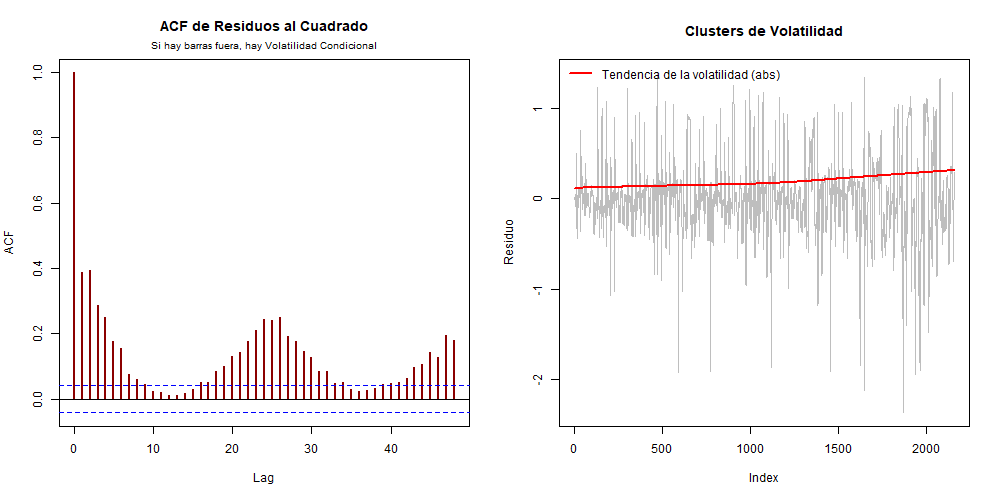

In [20]:
%%R -w 1000 -h 500

serie_residuos <- na.omit(df_r$Trend_Removed)

par(mfrow=c(1,2))

# 1. ACF de los residuos al cuadrado (Proxy visual de heterocedasticidad)
acf(serie_residuos^2, lag.max=48, main="ACF de Residuos al Cuadrado", col="darkred", lwd=2)
mtext("Si hay barras fuera, hay Volatilidad Condicional", side=3, line=0.5, cex=0.8)

# 2. Test McLeod-Li visual
# (Requiere librería TSA o forecast checkresiduals, pero podemos hacerlo manual con Ljung-Box en cuadrados)
# Aquí hacemos un gráfico simple de los residuos
plot(serie_residuos, type="l", col="gray", main="Clusters de Volatilidad", ylab="Residuo")
lines(lowess(abs(serie_residuos)), col="red", lwd=2)
legend("topleft", legend="Tendencia de la volatilidad (abs)", col="red", lwd=2, bty="n")

# --- REPORTE ---
cat("\n=======================================================\n")
cat(" 3. PRUEBA DE HETEROCEDASTICIDAD (Efectos ARCH)\n")
cat("=======================================================\n")

# Test ARCH-LM
cat("\n[A] ARCH-LM Test (Lagrange Multiplier)\n")
cat("    H0: No hay efectos ARCH (Varianza constante)\n")
test_arch <- ArchTest(serie_residuos, lags=24) # Lag 24 por ciclo diario
interpret_p(test_arch$p.value, h0_desc="Homocedastico (Varianza estable)", h1_desc="Heterocedastico (Hay efectos ARCH)")

if(test_arch$p.value < 0.05) {
    cat("\n>>> RECOMENDACION: Considerar modelos GARCH o metodos que manejen varianza variable.\n")
}


 4. PUNTOS DE CAMBIO ESTRUCTURAL (Change Points)
<U+2705> No se detectaron cambios estructurales significativos en la media.


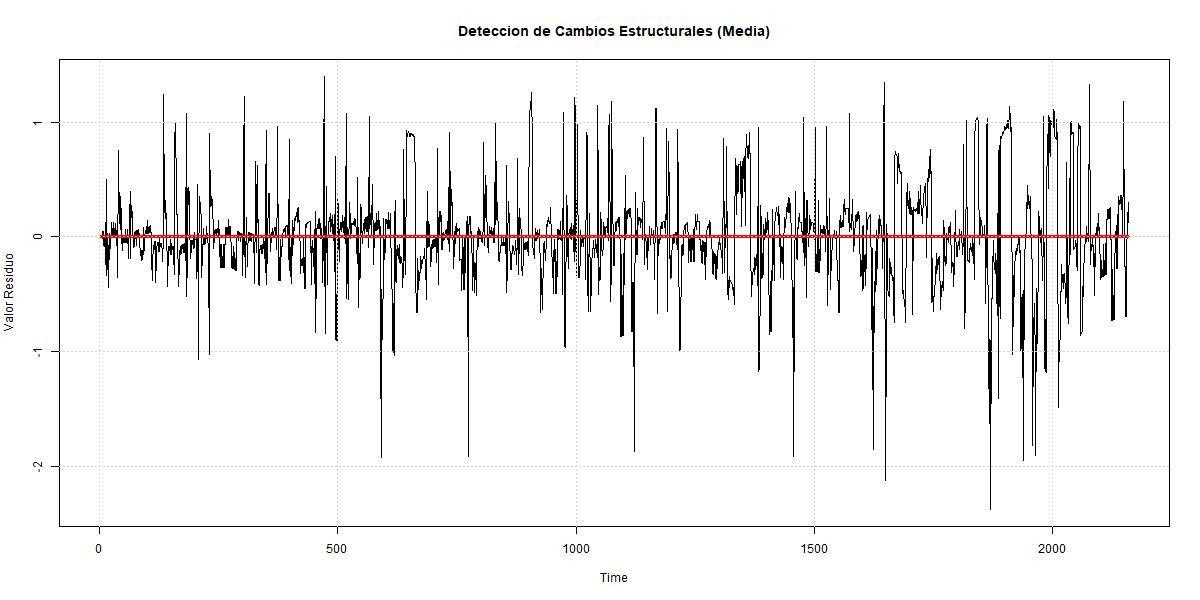

In [21]:
%%R -w 1200 -h 600

# Usamos método PELT (Pruned Exact Linear Time) que es rápido
# penalty="BIC" penaliza encontrar demasiados puntos falsos
cpt_obj <- cpt.mean(df_r$Trend_Removed, method="PELT", penalty="BIC")

# Extraer puntos
cpts_indices <- cpts(cpt_obj)

plot(cpt_obj, type="l", cpt.col="red", cpt.width=3, 
     main="Deteccion de Cambios Estructurales (Media)", 
     ylab="Valor Residuo")
grid()

cat("\n=======================================================\n")
cat(" 4. PUNTOS DE CAMBIO ESTRUCTURAL (Change Points)\n")
cat("=======================================================\n")

if(length(cpts_indices) > 0) {
    cat(paste("Se detectaron", length(cpts_indices), "cambios abruptos en la media.\n"))
    cat("Indices aproximados:", paste(head(cpts_indices, 5), collapse=", "), "...\n")
    cat("Fechas (Primeros 3):", paste(df_r$Date[head(cpts_indices, 3)], collapse=", "), "\n")
} else {
    cat("✅ No se detectaron cambios estructurales significativos en la media.\n")
}


 5. DIAGNOSTICO DE RESIDUOS (Normalidad y Autocorrelacion)

[A] Jarque-Bera Test (Normalidad)
    H0: Los datos se distribuyen normalmente
   -> p-value: 0.00000 (***) 
   -> Conclusion: [!] No Normal (Colas pesadas)

[B] Ljung-Box Test (Ruido Blanco)
    H0: Datos independientes (Sin correlacion serial)
   -> p-value: 0.00000 (***) 
   -> Conclusion: [!] Aun queda autocorrelacion

-------------------------------------------------------
INTERPRETACION FINAL:
1. Si da 'No Normal': Es esperado en electricidad (Kurtosis alta).
   Justifica el uso de evaluacion probabilistica (CRPS) sobre MSE.

2. Si da 'Aun queda autocorrelacion':
   Significa que Lowess no capturo toda la dinamica temporal.
   Los modelos ARMA/LSTM posteriores se encargaran de esto.


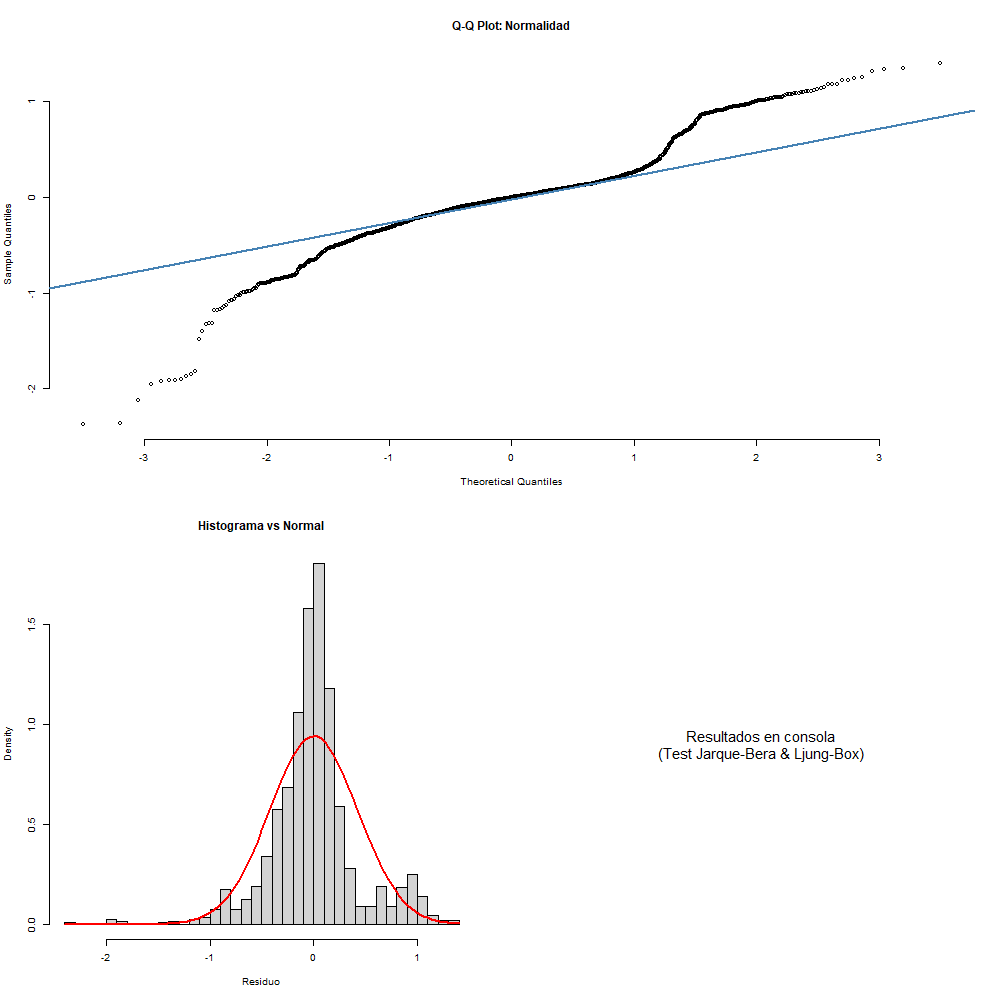

In [23]:
%%R -w 1000 -h 1000

# Datos a analizar
serie_final <- na.omit(df_r$Trend_Removed)

# Configuracion de graficos (2x2)
layout(matrix(c(1,1,2,3), 2, 2, byrow = TRUE))

# 1. QQ-Plot
qqnorm(serie_final, pch = 1, frame = FALSE, main="Q-Q Plot: Normalidad")
qqline(serie_final, col = "steelblue", lwd = 2)

# 2. Histograma
hist(serie_final, breaks=50, probability=TRUE, col="lightgrey", main="Histograma vs Normal", xlab="Residuo")
curve(dnorm(x, mean=mean(serie_final), sd=sd(serie_final)), col="red", lwd=2, add=TRUE)

# 3. Placeholder visual
plot(1, type="n", axes=F, xlab="", ylab="")
text(1, 1, "Resultados en consola\n(Test Jarque-Bera & Ljung-Box)", cex=1.5)

# --- FUNCION LIMPIA (SOLO ASCII) ---
interpret_p <- function(p_val, alpha=0.05, h0_desc, h1_desc) {
    res <- ifelse(p_val < alpha, h1_desc, h0_desc)
    # Marcas de significancia simples
    signif <- ifelse(p_val < 0.001, "***", ifelse(p_val < 0.01, "**", ifelse(p_val < 0.05, "*", "ns")))
    cat(sprintf("   -> p-value: %.5f (%s) \n   -> Conclusion: %s\n", p_val, signif, res))
}

# --- REPORTES DE TEXTO (SIN TILDES NI EMOJIS) ---
cat("\n=======================================================\n")
cat(" 5. DIAGNOSTICO DE RESIDUOS (Normalidad y Autocorrelacion)\n")
cat("=======================================================\n")

# A. Jarque-Bera
cat("\n[A] Jarque-Bera Test (Normalidad)\n")
cat("    H0: Los datos se distribuyen normalmente\n")
jb_test <- jarque.bera.test(serie_final)
interpret_p(jb_test$p.value, h0_desc="[OK] Normal", h1_desc="[!] No Normal (Colas pesadas)")

# B. Ljung-Box
cat("\n[B] Ljung-Box Test (Ruido Blanco)\n")
cat("    H0: Datos independientes (Sin correlacion serial)\n")
# Usamos lag=24 porque tus datos son horarios
lb_test <- Box.test(serie_final, lag=24, type="Ljung-Box") 
interpret_p(lb_test$p.value, h0_desc="[OK] Ruido Blanco", h1_desc="[!] Aun queda autocorrelacion")

cat("\n-------------------------------------------------------\n")
cat("INTERPRETACION FINAL:\n")
cat("1. Si da 'No Normal': Es esperado en electricidad (Kurtosis alta).\n")
cat("   Justifica el uso de evaluacion probabilistica (CRPS) sobre MSE.\n\n")
cat("2. Si da 'Aun queda autocorrelacion':\n")
cat("   Significa que Lowess no capturo toda la dinamica temporal.\n")
cat("   Los modelos ARMA/LSTM posteriores se encargaran de esto.\n")

In [45]:
# Enriquecer dataset para boxplots
df['Hora'] = df.index.hour
df['Dia_Semana'] = df.index.day_name()
df['Mes'] = df.index.month_name()

# 1. Por Hora (Ciclo Diario - Fundamental en electricidad)
fig = px.box(df, x='Hora', y='Trend_Removed', 
             title='Box Plot: Estacionalidad Diaria (Por Hora)', color_discrete_sequence=['blue'])
fig.update_layout(title_x=0.5)
fig.show()

# 2. Por Día de la Semana
dias_orden = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
fig = px.box(df, x='Dia_Semana', y='Trend_Removed', category_orders={"Dia_Semana": dias_orden},
             title='Box Plot: Estacionalidad Semanal', color_discrete_sequence=['orange'])
fig.update_layout(title_x=0.5)
fig.show()

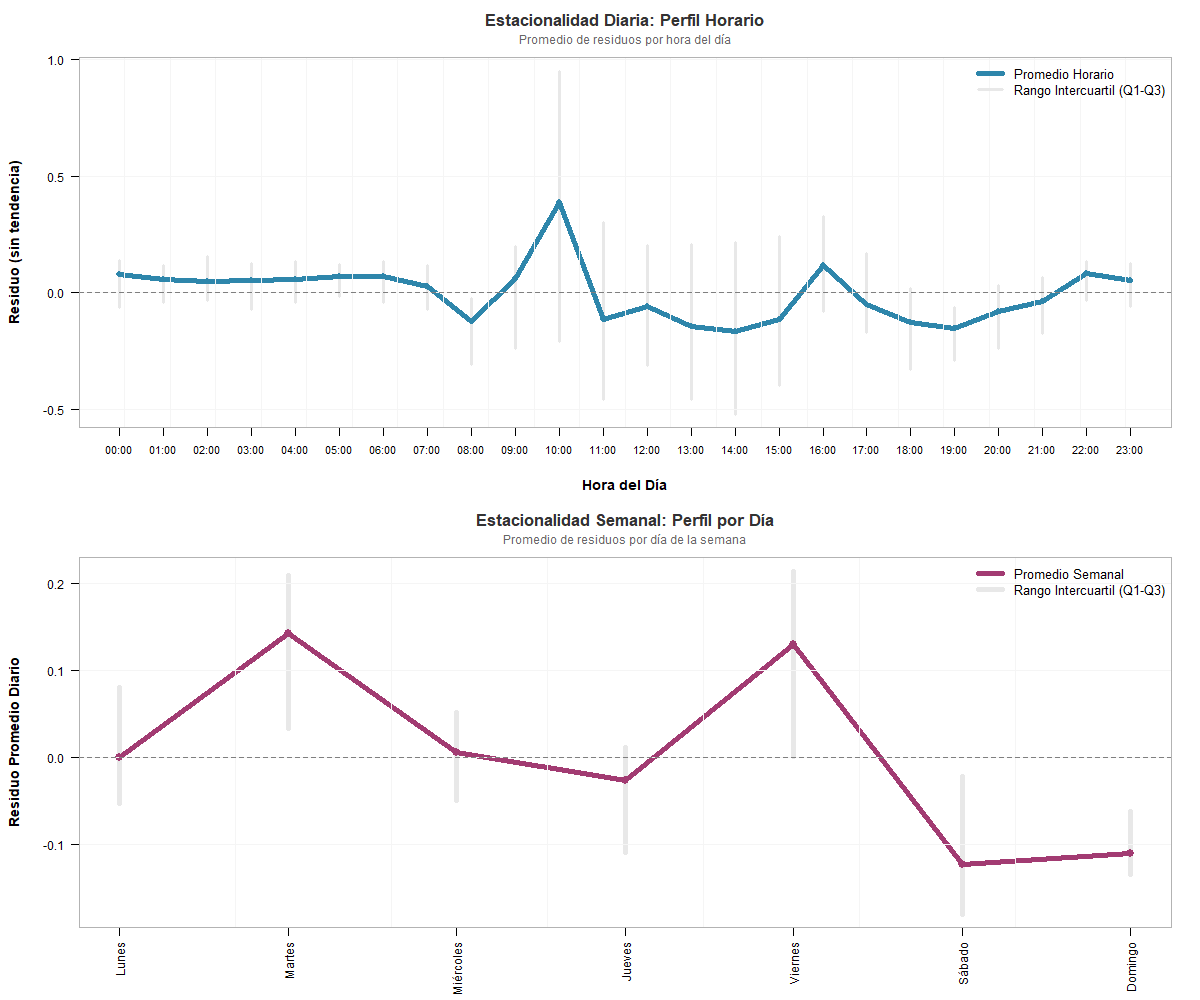

In [60]:
%%R -w 1200 -h 1000

library(dplyr)
library(lubridate)

# Paleta de colores moderna
col_daily <- "#2E86AB"      # Azul profundo
col_weekly <- "#A23B72"     # Magenta oscuro
col_base <- "#E8E8E8"       # Gris claro para variación
col_grid <- "#F5F5F5"       # Grid muy suave

# Configuración del panel mejorada
layout(matrix(c(1, 2), nrow = 2, ncol = 1))
par(mar = c(5, 5.5, 4, 2), 
    bg = "white",
    family = "sans")

# ==============================================================================
# 1. ESTACIONALIDAD DIARIA (Ciclo de 24 Horas)
# ==============================================================================

# Calcular promedios por hora
hourly_stats <- df_r %>%
  mutate(Hour = hour(Date)) %>%
  group_by(Hour) %>%
  summarise(
    Mean = mean(Trend_Removed, na.rm = TRUE),
    SD = sd(Trend_Removed, na.rm = TRUE),
    Q25 = quantile(Trend_Removed, 0.25, na.rm = TRUE),
    Q75 = quantile(Trend_Removed, 0.75, na.rm = TRUE)
  )

# Crear el gráfico base
plot(hourly_stats$Hour, hourly_stats$Mean,
     type = "n",
     xlim = c(0, 23),
     ylim = range(c(hourly_stats$Q25, hourly_stats$Q75)),
     xlab = "",
     ylab = "",
     main = "",
     xaxt = "n",
     las = 1)

# Agregar bandas de cuartiles (variación)
for(i in 1:nrow(hourly_stats)) {
  segments(hourly_stats$Hour[i], hourly_stats$Q25[i],
           hourly_stats$Hour[i], hourly_stats$Q75[i],
           col = col_base, lwd = 3)
}

# Agregar línea de media
lines(hourly_stats$Hour, hourly_stats$Mean, 
      col = col_daily, lwd = 5)

# Agregar puntos en la media
points(hourly_stats$Hour, hourly_stats$Mean,
       col = col_daily, pch = 19, cex = 1.2)

# Ejes y títulos
axis(1, at = 0:23, labels = sprintf("%02d:00", 0:23), cex.axis = 0.9)
mtext("Estacionalidad Diaria: Perfil Horario", 
      side = 3, line = 2, cex = 1.4, font = 2, col = "gray20")
mtext("Promedio de residuos por hora del día", 
      side = 3, line = 0.8, cex = 1, col = "gray40")
mtext("Hora del Día", side = 1, line = 3.5, cex = 1.2, font = 2)
mtext("Residuo (sin tendencia)", side = 2, line = 4, cex = 1.2, font = 2)

# Grid y línea de referencia
grid(nx = 24, ny = NULL, col = col_grid, lty = 1, lwd = 1.5)
abline(h = 0, col = "gray50", lty = 2, lwd = 1.5)

# Leyenda
legend("topright", 
       legend = c("Promedio Horario", "Rango Intercuartil (Q1-Q3)"), 
       col = c(col_daily, col_base), 
       lty = 1, 
       lwd = c(5, 3), 
       bty = "n", 
       cex = 1.1,
       bg = "white")

# Caja alrededor del gráfico
box(col = "gray70", lwd = 1.5)


# ==============================================================================
# 2. ESTACIONALIDAD SEMANAL (Ciclo de 7 Días)
# ==============================================================================

# Calcular promedios por día de la semana
daily_agg <- df_r %>%
  mutate(Date_Day = as.Date(Date),
         Weekday = wday(Date_Day, week_start = 1)) %>%  # 1=Lunes, 7=Domingo
  group_by(Date_Day, Weekday) %>%
  summarise(Value = mean(Trend_Removed, na.rm = TRUE), .groups = "drop")

weekly_stats <- daily_agg %>%
  group_by(Weekday) %>%
  summarise(
    Mean = mean(Value, na.rm = TRUE),
    SD = sd(Value, na.rm = TRUE),
    Q25 = quantile(Value, 0.25, na.rm = TRUE),
    Q75 = quantile(Value, 0.75, na.rm = TRUE)
  )

# Nombres de días en español
dias_semana <- c("Lunes", "Martes", "Miércoles", "Jueves", 
                 "Viernes", "Sábado", "Domingo")

# Crear el gráfico base
plot(weekly_stats$Weekday, weekly_stats$Mean,
     type = "n",
     xlim = c(1, 7),
     ylim = range(c(weekly_stats$Q25, weekly_stats$Q75)),
     xlab = "",
     ylab = "",
     main = "",
     xaxt = "n",
     las = 1)

# Agregar bandas de cuartiles (variación)
for(i in 1:nrow(weekly_stats)) {
  segments(weekly_stats$Weekday[i], weekly_stats$Q25[i],
           weekly_stats$Weekday[i], weekly_stats$Q75[i],
           col = col_base, lwd = 5)
}

# Agregar línea de media
lines(weekly_stats$Weekday, weekly_stats$Mean, 
      col = col_weekly, lwd = 5)

# Agregar puntos en la media
points(weekly_stats$Weekday, weekly_stats$Mean,
       col = col_weekly, pch = 19, cex = 1.5)

# Ejes y títulos
axis(1, at = 1:7, labels = dias_semana, cex.axis = 1, las = 2)
mtext("Estacionalidad Semanal: Perfil por Día", 
      side = 3, line = 2, cex = 1.4, font = 2, col = "gray20")
mtext("Promedio de residuos por día de la semana", 
      side = 3, line = 0.8, cex = 1, col = "gray40")
mtext("Día de la Semana", side = 1, line = 5.5, cex = 1.2, font = 2)
mtext("Residuo Promedio Diario", side = 2, line = 4, cex = 1.2, font = 2)

# Grid y línea de referencia
grid(nx = 7, ny = NULL, col = col_grid, lty = 1, lwd = 1.5)
abline(h = 0, col = "gray50", lty = 2, lwd = 1.5)

# Leyenda
legend("topright", 
       legend = c("Promedio Semanal", "Rango Intercuartil (Q1-Q3)"), 
       col = c(col_weekly, col_base), 
       lty = 1, 
       lwd = c(5, 5), 
       bty = "n", 
       cex = 1.1,
       bg = "white")

# Caja alrededor del gráfico
box(col = "gray70", lwd = 1.5)

[1] "Periodo Dominante en R: 83.0769 horas"


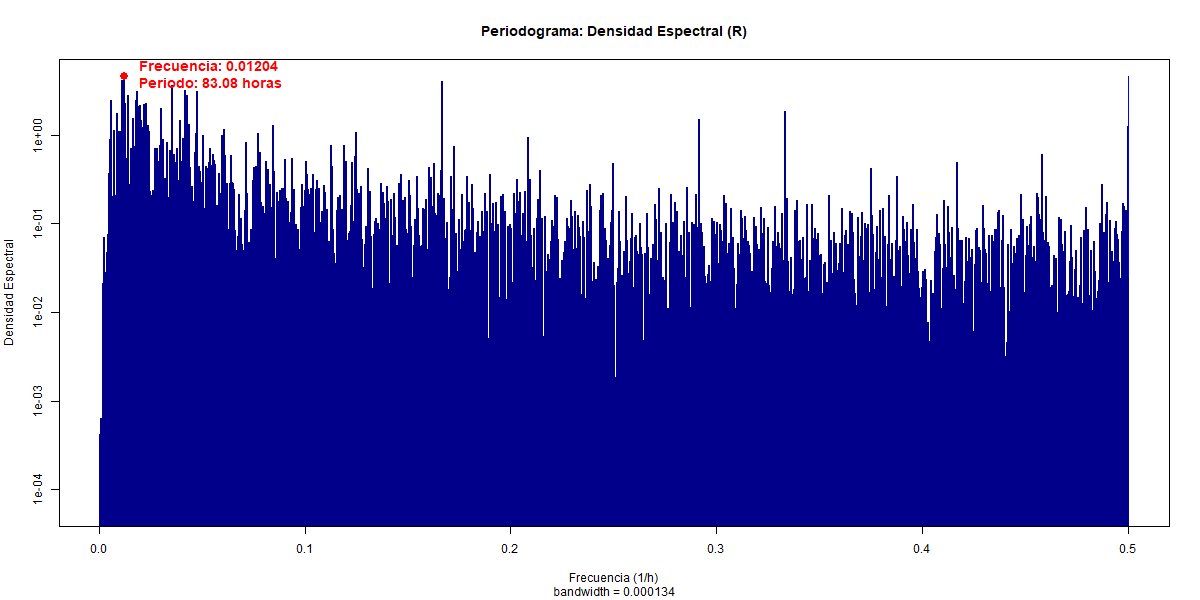

In [61]:
%%R -w 1200 -h 600

# 1. Preparar datos (quitamos NAs generados por el filtro de tendencia)
clean_data <- na.omit(df_r$Trend_Removed)

# 2. Calcular el periodograma
# log='no' para ver la densidad espectral cruda
Periogram <- spectrum(as.numeric(clean_data), log = 'no', plot = FALSE)

# 3. Encontrar el pico máximo
ubicacion <- which.max(Periogram$spec)
max_freq <- Periogram$freq[ubicacion]
max_spec <- Periogram$spec[ubicacion]

# 4. Calcular el periodo correspondiente (1 / frecuencia)
max_period <- 1 / max_freq

# 5. Graficar
plot(Periogram, 
     main = "Periodograma: Densidad Espectral (R)",
     xlab = "Frecuencia (1/h)",
     ylab = "Densidad Espectral",
     col = "darkblue", lwd = 2, type="h")

# Marcamos el punto máximo
points(max_freq, max_spec, col = "red", pch = 19, cex = 1.5)

# 6. Texto dinámico (ajustado para que no quede fuera del gráfico)
# Usamos max_spec para la altura y max_freq para la posición X
text_x <- max_freq
text_y <- max_spec

text(text_x, text_y, 
     sprintf("  Frecuencia: %.5f\n  Periodo: %.2f horas", max_freq, max_period), 
     pos = 4,      # Texto a la derecha del punto
     col = "red", 
     cex = 1.2, 
     font = 2)

print(paste("Periodo Dominante en R:", round(max_period, 4), "horas"))

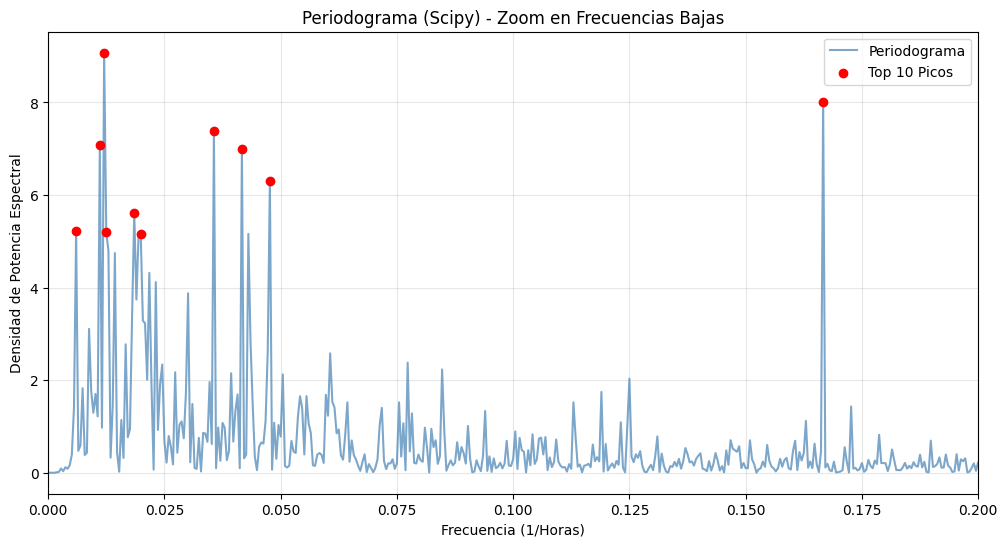

--- Los 10 Picos más grandes (Periodograma) ---


,0,1,2,3,4,5,6,7,8,9
Frecuencia,0.012037,0.166667,0.035648,0.011111,0.041667,0.047685,0.018519,0.006019,0.012500,0.019907
Periodo (Horas),83.076923,6.000000,28.051948,90.000000,24.000000,20.970874,54.000000,166.153846,80.000000,50.232558
Densidad Potencia,9.073767,8.015363,7.393022,7.086866,7.001416,6.302915,5.610105,5.211598,5.193203,5.160935


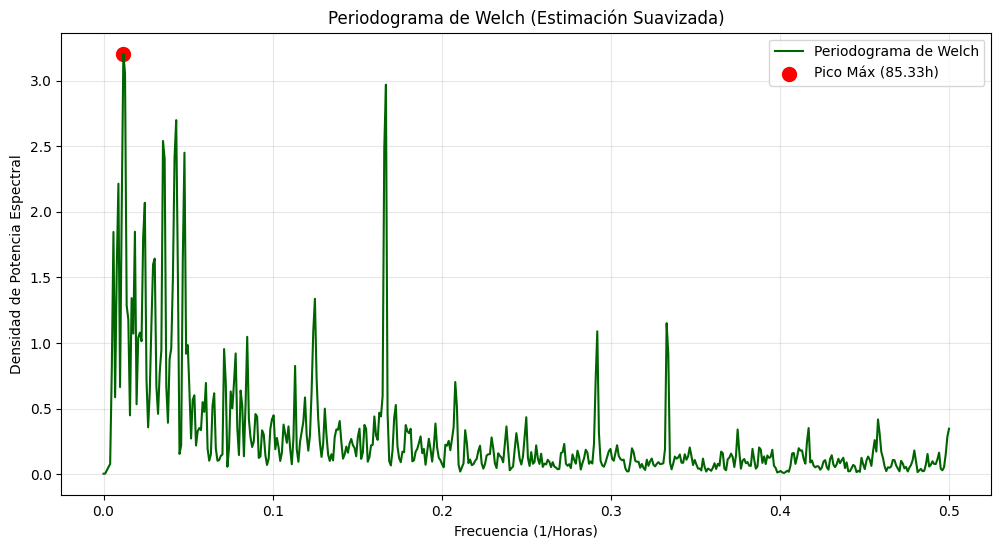


RESULTADO WELCH:
--------------------------------------------
El pico más notorio se da: 
 - Frecuencia: 0.01172 Hz (ciclos/hora)
 - Periodo:    85.33 Horas
 - Densidad:   3.21
--------------------------------------------



In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import heapq

# 1. Preparar datos (Eliminar NAs es crucial para FFT)
trend_removed = df['Trend_Removed'].dropna()

# ==========================================
# A. PERIODOGRAMA ESTÁNDAR
# ==========================================

# Calcular el periodograma
f, Pxx_den = signal.periodogram(trend_removed)

# Encontrar los 10 picos más importantes
# Usamos heapq para buscar los índices de los valores más altos
peaks_indices = heapq.nlargest(10, range(len(Pxx_den)), key=Pxx_den.__getitem__)

f_freq = f[peaks_indices]
densidad = Pxx_den[peaks_indices]

# Evitar división por cero si la frecuencia 0 (DC) es seleccionada
with np.errstate(divide='ignore'):
    f_period = 1 / f_freq

# Graficar el periodograma estándar
plt.figure(figsize=(12, 6))
plt.plot(f, Pxx_den, label='Periodograma', color='steelblue', alpha=0.7)
plt.scatter(f[peaks_indices], Pxx_den[peaks_indices], color='red', zorder=5, label='Top 10 Picos')

# Zoom opcional: limitamos X para ver mejor las frecuencias bajas (donde están los ciclos de 24h y 168h)
plt.xlim(0, 0.2) 

plt.xlabel('Frecuencia (1/Horas)')
plt.ylabel('Densidad de Potencia Espectral')
plt.title('Periodograma (Scipy) - Zoom en Frecuencias Bajas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print('--- Los 10 Picos más grandes (Periodograma) ---')

# Crear DataFrame con resultados
data = {
    'Frecuencia': f_freq, 
    'Periodo (Horas)': f_period, 
    'Densidad Potencia': densidad
}
df_frecuencias_periodos = pd.DataFrame(data).sort_values(by='Densidad Potencia', ascending=False)

# Mostrar tabla traspuesta para fácil lectura
display(df_frecuencias_periodos.T)


# ==========================================
# B. PERIODOGRAMA DE WELCH (Más suave)
# ==========================================

# Calcular Welch (nperseg define la resolución, 1024 es bueno para hourly)
f_welch, Pxx_den_welch = signal.welch(trend_removed, nperseg=1024)

# Encontrar el pico más alto
max_index_value_welch = np.argmax(Pxx_den_welch)
frecuencia_max_welch = f_welch[max_index_value_welch]
frecuencia_pico_welch = 1 / frecuencia_max_welch
max_densidad_welch = Pxx_den_welch[max_index_value_welch]

# Graficar Welch
plt.figure(figsize=(12, 6))
plt.plot(f_welch, Pxx_den_welch, label='Periodograma de Welch', color='darkgreen')
plt.scatter(frecuencia_max_welch, max_densidad_welch, color='red', s=100, label=f'Pico Máx ({frecuencia_pico_welch:.2f}h)')

plt.xlabel('Frecuencia (1/Horas)')
plt.ylabel('Densidad de Potencia Espectral')
plt.title('Periodograma de Welch (Estimación Suavizada)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"""
RESULTADO WELCH:
--------------------------------------------
El pico más notorio se da: 
 - Frecuencia: {frecuencia_max_welch:.5f} Hz (ciclos/hora)
 - Periodo:    {frecuencia_pico_welch:.2f} Horas
 - Densidad:   {max_densidad_welch:.2f}
--------------------------------------------
""")

# Modelación

In [65]:
# CELDA MÁGICA - EJECÚTALA PRIMERO EN TU NOTEBOOK ARMA.ipynb
import sys
import os

# Ruta al directorio que contiene todos los módulos (codigo_base)
CODE_BASE_PATH = r"C:\Users\pleal\Documents\Unal\Tesis\Codigo\Prediccion_Probabilistica\codigo_final_organizado\Aplicaciones\Aplicaciones_con_analisis\codigo_base"

# Añadimos al path para que Python los encuentre
if CODE_BASE_PATH not in sys.path:
    sys.path.insert(0, CODE_BASE_PATH)

print("Módulos cargados correctamente desde codigo_base")
print("Puedes usar: simulacion, pipeline, modelos, figuras, etc.")

Módulos cargados correctamente desde codigo_base
Puedes usar: simulacion, pipeline, modelos, figuras, etc.


In [67]:
import os
import pandas as pd
import numpy as np
from pipeline import PipelineProcessedData
# Importamos las funciones específicas de tu archivo plot.py
from plot import (
    generate_validation_report, 
    get_model_colors, 
    plot_type_a_vertical_stack, 
    plot_type_b_step_comparison, 
    run_advanced_statistics
)

# =============================================================================
# 1. EJECUCIÓN DEL MODELO (PIPELINE)
# =============================================================================
print("🚀 Iniciando Ejecución del Pipeline sobre datos procesados...")

# Asegúrate de tener la serie limpia (sin NaNs)
input_series = df['Trend_Removed'].dropna()

# Instanciar Pipeline
pipeline = PipelineProcessedData(n_boot=1000, seed=42, verbose=True)

# Ejecutar y obtener resultados crudos
# Es fundamental save_predictions=True para los gráficos de densidad
df_results, predictions_dict = pipeline.run_evaluation(input_series, save_predictions=True)

# =============================================================================
# 2. GENERACIÓN DE REPORTES Y GRAFICAS (ORQUESTADOR PERSONALIZADO)
# =============================================================================
output_folder = "Resultados_Analisis"
output_prefix = "Trend_Removed"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"📂 Carpeta creada: {output_folder}")

print(f"\n📊 Generando Reportes en '{output_folder}'...")

# A. Identificar Modelos y Colores
model_names = [c for c in df_results.columns if c not in ['Paso', 'Valor_Observado', 'timestamp']]
color_map = get_model_colors(model_names)

# B. Generar Diagnóstico (PIT / Reliability)
# Esto retorna el DataFrame con datos de confiabilidad y guarda las imgs PIT/Reliability
df_reliability = generate_validation_report(predictions_dict, output_folder, output_prefix, color_map)

# C. GUARDAR EXCEL COMPLETO (CRPS + Reliability)
excel_name = os.path.join(output_folder, f"{output_prefix}_Resultados_Completos.xlsx")
with pd.ExcelWriter(excel_name, engine='openpyxl') as writer:
    df_results.to_excel(writer, sheet_name='Metricas_CRPS_Paso_a_Paso', index=False)
    if not df_reliability.empty:
        df_reliability.to_excel(writer, sheet_name='Reliability_Data', index=False)

print(f"💾 Excel guardado exitosamente: {excel_name}")

# =============================================================================
# 3. GENERACIÓN DE IMÁGENES
# =============================================================================

# Definir ranking para saber cuáles graficar juntos
# Calculamos el CRPS promedio por modelo
mean_scores = df_results[model_names].mean().sort_values()
sorted_models = mean_scores.index.tolist()

top_3_best = sorted_models[:3]
top_3_worst = sorted_models[-3:]
# Top 2 mejores + El peor (para contraste)
top_mixed = sorted_models[:2] + [sorted_models[-1]]

print("\n📸 Generando Gráficos Tipo A (Vertical Stack - Evolución Temporal)...")

# 1. Gráficos Individuales (Uno por modelo)
for model in model_names:
    plot_type_a_vertical_stack(
        group_name=f"Model_{model}",
        models_to_plot=[model],
        predictions_dict=predictions_dict,
        df_results=df_results,
        model_colors=color_map,
        output_folder=output_folder,
        output_prefix=output_prefix
    )

# 2. Gráficos Comparativos
if len(model_names) >= 3:
    plot_type_a_vertical_stack("Top3_Mejores", top_3_best, predictions_dict, df_results, color_map, output_folder, output_prefix)
    plot_type_a_vertical_stack("Top3_Peores", top_3_worst, predictions_dict, df_results, color_map, output_folder, output_prefix)
plot_type_a_vertical_stack("VS_Mejores_y_Peor", top_mixed, predictions_dict, df_results, color_map, output_folder, output_prefix)


print("\n📸 Generando Gráficos Tipo B (Corte Transversal - Pasos Específicos)...")
# Graficamos pasos clave: 1, 6, 12, 18, 24 (ajustable)
target_steps = [1, 6, 12, 18, 24]
for step in target_steps:
    if step <= len(predictions_dict):
        plot_type_b_step_comparison(
            target_step_idx=step,
            predictions_dict=predictions_dict,
            df_results=df_results,
            all_models=model_names,
            model_colors=color_map,
            output_folder=output_folder,
            output_prefix=output_prefix
        )

# =============================================================================
# 4. ANÁLISIS ESTADÍSTICO FINAL
# =============================================================================
print("\n🔬 Ejecutando Test de Diebold-Mariano y Rankings...")
run_advanced_statistics(df_results, output_folder)

print(f"\n✅ ¡PROCESO FINALIZADO! Revisa la carpeta: {os.path.abspath(output_folder)}")

🚀 Iniciando Ejecución del Pipeline sobre datos procesados...
📥 PROCESSED DATA PIPELINE (Datos Recibidos: 2160 puntos)

⚡ OPTIMIZACIÓN EFICIENTE (9 Modelos)


Optimizando DeepAR:  78%|███████▊  | 7/9 [01:16<00:20, 10.13s/modelo]             

  Early stopping at epoch 8
  Early stopping at epoch 8
  Early stopping at epoch 7
  Early stopping at epoch 10
  Early stopping at epoch 9
  Early stopping at epoch 7
  Early stopping at epoch 11
  Early stopping at epoch 13
  Early stopping at epoch 9
  Early stopping at epoch 15
  Early stopping at epoch 11
  Early stopping at epoch 11
  Early stopping at epoch 9
  Early stopping at epoch 10
  Early stopping at epoch 10
  Early stopping at epoch 12
  Early stopping at epoch 12
  Early stopping at epoch 15
  Early stopping at epoch 7


Optimizando EnCQR-LSTM: 100%|██████████| 9/9 [31:30<00:00, 210.04s/modelo]



🔒 Fase 2: Congelamiento (Entrenamiento Final)


Congelando modelos:  67%|██████▋   | 6/9 [00:00<00:00, 34.89it/s]

  CBB congelado: block_length=24
  Sieve Bootstrap congelado: order=12, n_residuos=2124
  LSPM congelado: n_lags=12
  LSPM congelado: n_lags=12
  ✅ LSPMW congelado: ρ=0.95, n_lags=12, n_critical=2123
  AREPD congelado: n_lags=24, rho=0.9, mean=-0.0012, std=0.4240
  MCPS congelado: n_lags=24, n_bins=10
  DeepAR congelado: mean=-0.0012, std=0.4240, model_trained=True


Congelando modelos: 100%|██████████| 9/9 [00:57<00:00,  6.38s/it]


  ✓ EnCQR-LSTM congelado con KDE: n_lags=24, B=3, units=48

🔮 Fase 3: Predicción (24 pasos)


Prediciendo Steps: 100%|██████████| 24/24 [00:45<00:00,  1.90s/it]


📂 Carpeta creada: Resultados_Analisis

📊 Generando Reportes en 'Resultados_Analisis'...
 📊 Generando Reporte Estadístico Agregado (Diagnóstico)...
💾 Excel guardado exitosamente: Resultados_Analisis\Trend_Removed_Resultados_Completos.xlsx

📸 Generando Gráficos Tipo A (Vertical Stack - Evolución Temporal)...

📸 Generando Gráficos Tipo B (Corte Transversal - Pasos Específicos)...

🔬 Ejecutando Test de Diebold-Mariano y Rankings...

🔬 Ejecutando Análisis Estadístico en 'Resultados_Analisis\Analisis'...
   ✓ Ranking DM guardado: Resultados_Analisis\Analisis\Ranking_Estadistico_DM.xlsx

✅ ¡PROCESO FINALIZADO! Revisa la carpeta: c:\Users\pleal\Documents\Unal\Tesis\Codigo\Prediccion_Probabilistica\codigo_final_organizado\Aplicaciones\Aplicaciones_con_analisis\Resultados_Analisis
